
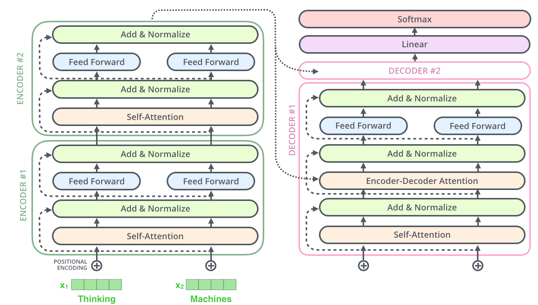



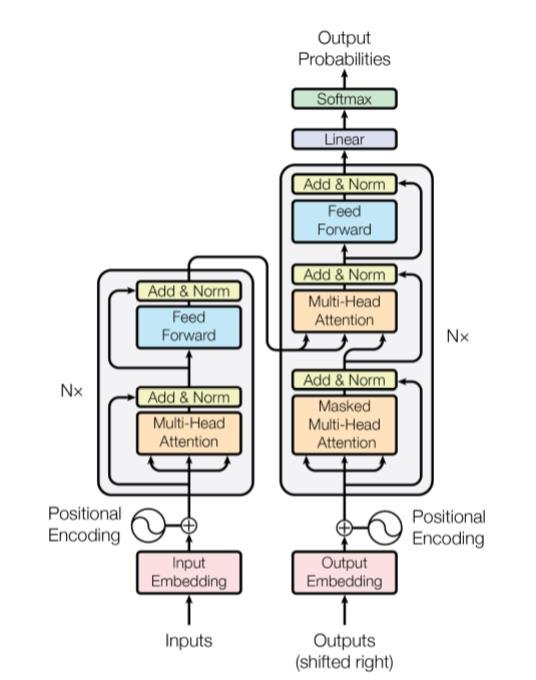

## data

OK.ru data

In [ ]:
!wget https://cups.mail.ru/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo  -O toxic.csv

--2022-06-14 14:13:57--  https://cups.mail.ru/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo
Resolving cups.mail.ru (cups.mail.ru)... 188.93.56.95
Connecting to cups.mail.ru (cups.mail.ru)|188.93.56.95|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cups.online/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo [following]
--2022-06-14 14:13:57--  https://cups.online/media/tasks/round_594/task_1048/e34f37b8ae4e0efeb6ffd0f63969a85e_i8eF0Bo
Resolving cups.online (cups.online)... 188.93.56.95
Connecting to cups.online (cups.online)|188.93.56.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24525472 (23M) [application/octet-stream]
Saving to: ‘toxic.csv’

toxic.csv           100%[===================>]  23.39M  12.5MB/s    in 1.9s    

2022-06-14 14:14:00 (12.5 MB/s) - ‘toxic.csv’ saved [24525472/24525472]



In [ ]:
!head toxic.csv

41127	__label__THREAT	дворника надо тоже уничтожить!
6812	__label__NORMAL	моя старшая неделю шипела, не принимала подкидыша, которого я принесла. китя такой славный, потерпите немного, мои теперь душа в душу живут, ваша примет попозже. а котенок необыкновенно красивый.
6256	__label__NORMAL	полностью с вами согласна!
189636	__label__NORMAL	хоть ногу вверх, ничего не изменится
99053	__label__NORMAL	а что значит - левого ребенка?
98418	__label__NORMAL	вечер добрый! а, что он у вас уже постарел?!
3619	__label__NORMAL	какая порода .?
176463	__label__INSULT	спасатель? просто петух чванливый, взял наших пацанов в заложники и торгуется. позор! как бы сам в щи не попал.
13520	__label__NORMAL	с замечательным юбилеем!!! голос- чудо, заслушаешься 😍и про чтение все правильно- ничто не сравнится с бумажной книгой!
133613	__label__NORMAL	еще бы .такой красавец.


In [ ]:
!wget http://paraphraser.ru/download/get?file_id=7 -O paraphrase.zip

--2023-10-16 16:43:00--  http://paraphraser.ru/download/get?file_id=7
Resolving paraphraser.ru (paraphraser.ru)... 91.122.14.248
Connecting to paraphraser.ru (paraphraser.ru)|91.122.14.248|:80... connected.
HTTP request sent, awaiting response... 403 Forbidden
2023-10-16 16:43:01 ERROR 403: Forbidden.



In [ ]:
!unzip paraphrase.zip

Archive:  paraphrase.zip
   creating: ParaPhraserPlus/
  inflating: ParaPhraserPlus/ParaPhraserPlus.json  


## import/install libs

In [ ]:
!pip install transformers
!pip install faiss-gpu
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.3 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 101 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 29.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=460c3d0603335ce0e45b811139ceccb357fb26f4b3f464a324e4ab0c6e2b

In [ ]:
import re
import os
import sys
import json
import nltk
from tqdm import tqdm
import gc

import logging
import numpy as np
import pandas as pd

from scipy.stats import spearmanr, pearsonr
from glob import glob

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import faiss

## semantic space & search


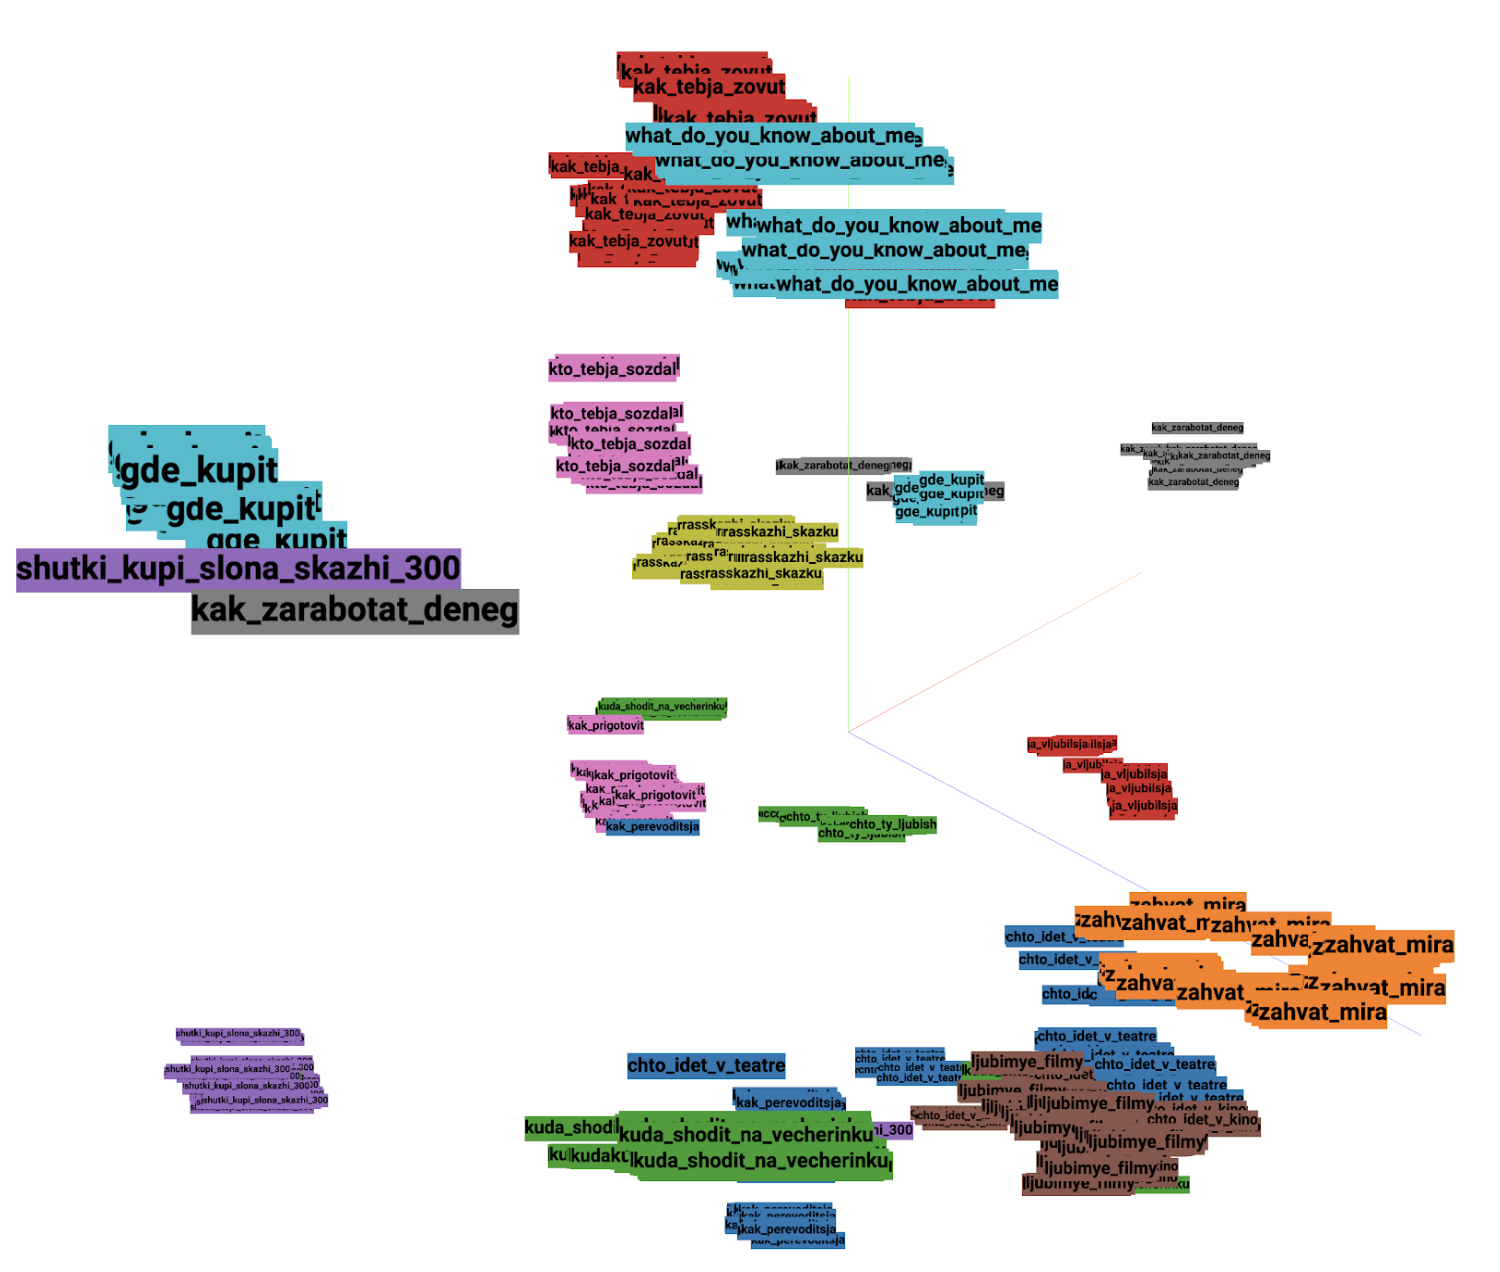




In [ ]:
with open('//content/ParaPhraserPlus/ParaPhraserPlus.json', 'r') as f:
    para=json.load(f)

In [ ]:
rubrics = []
for k in para.keys():
  r = para[k]['rubric']
  if r in rubrics:
    continue
  else:
    rubrics.append(r)
print('лист рубрик', rubrics)

лист рубрик ['общество', 'спорт', 'региональные', 'происшествия', 'конфликты', 'зарубежные', 'политика', 'наука', 'культура', 'экономика', 'события', 'медиа', 'авто', 'жкх', 'здоровье', 'животные']


In [ ]:
print('число инфоповодов' , len(para.keys()))

число инфоповодов 1725393


In [ ]:
science_news = []

for k in para.keys():
  r = para[k]['rubric']
  if r=='наука':
    science_news+=para[k]['headlines']
  else:
    continue
print('рубрика наука', len(science_news))

рубрика наука 84443


##### embeddings function

In [ ]:
class Data(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = np.array(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        return text

In [ ]:
# mean pooling: take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # first element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def get_embeddings(df, model, tokenizer, bsize=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
    model.to(device)
    model.eval()
    ldr_data = Data(data = df)
    loader = DataLoader(dataset = ldr_data, shuffle=False, batch_size = min([bsize, len(df)]))
    embeddings = []
    with torch.no_grad():
        for i, inputs in tqdm(enumerate(loader)):
            ## tokenize sentences
            batch = tokenizer(list(inputs), truncation=True, padding=True, return_tensors='pt', max_length=24)
            input_ids = batch['input_ids']
            input_ids = input_ids.to(device, dtype=torch.long)
            batch['input_ids'] = input_ids

            token_type_ids = batch['token_type_ids']
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            batch['token_type_ids'] = token_type_ids

            attention_mask = batch['attention_mask']
            attention_mask = attention_mask.to(device, dtype=torch.long)
            batch['attention_mask'] = attention_mask

            # compute token embeddings
            preds = model(**batch)
            # perform pooling. In this case, mean pooling
            preds = mean_pooling(preds, attention_mask)
            outputs = preds.cpu().detach().numpy()
            embeddings.extend(outputs)
    return np.array(embeddings)


# sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']

# load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")  #sberbank-ai/sbert_large_mt_nlu_ru
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

## tokenize sentences
#encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

#Compute token embeddings
#with torch.no_grad():
#    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
#sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

In [ ]:
sentences = ['Привет! Как твои дела?',
             'Как тваи елишки малышкО', 'Хачу гулять лео ведь']

In [ ]:
sentence_embeddings = get_embeddings(sentences, model, tokenizer, bsize = 256)

cuda is used


1it [00:00, 23.83it/s]


In [ ]:
np.dot(sentence_embeddings[0], sentence_embeddings[1])

121.20256

In [ ]:
sentence_embeddings

array([[ 0.4586771 , -0.2511485 , -0.45541745, ...,  0.32620454,
        -0.98523265,  0.20712778],
       [ 0.50019795, -0.04580222, -0.6035451 , ...,  0.34603205,
        -0.30684248,  0.28612503]], dtype=float32)

In [ ]:
sentence_embeddings = get_embeddings(science_news, model, tokenizer, bsize=1024)

cuda is used


83it [06:26,  4.66s/it]


In [ ]:
gc.collect()

52

In [ ]:
sentence_embeddings.shape

(84443, 1024)

In [ ]:
def sem_search(q, d_embs, values, bsize = 1024, top_k=5):
  query = get_embeddings(q, model, tokenizer, bsize=bsize)
  sim = np.matmul(query, d_embs.T)
  resp = values[np.argsort(-1*sim)[0][:top_k]]
  return resp

In [ ]:
sem_search(q=['сверхпроводимость открытия'],
           d_embs=sentence_embeddings,
           values = np.array(science_news),
           top_k=5)

cuda is used


1it [00:00, 41.65it/s]


array(['Нобелевские лауреаты Гейм и Новоселов открыли способ применения графена для увеличения скорости Интернета',
       'Открытый россиянами графен в сотни раз увеличит скорость работы интернета',
       'На Большом адронном коллайдере ученым впервые удалось получить стабильные атомы антиматерии',
       'Большой адронный коллайдер продемонстрировал новую физику частиц',
       'Открытие НАСА: 7 потенциально обитаемых экзопланет'],
      dtype='<U359')

In [ ]:
gc.collect()

211

#### UMAP maps of news rubrics

In [ ]:
def get_rndm_rubrics_data(rbrc, size=100):
  science_news = []
  for k in para.keys():
    r = para[k]['rubric']
    if r==rbrc:
      science_news+=para[k]['headlines']
    else:
      continue

  res = np.random.choice(science_news, size=size)
  del(science_news)
  gc.collect()

  return res

In [ ]:
umap_test_txt = {}
for rubr in ['спорт', 'наука', 'политика','здоровье','общество']:
  umap_test_txt[rubr]=get_rndm_rubrics_data(rubr)

In [ ]:
embs_all = [get_embeddings(umap_test_txt[rubr], model, tokenizer, bsize = 128) for rubr in ['спорт', 'наука', 'политика','здоровье','общество']]

cuda is used


1it [00:00,  1.04it/s]


cuda is used


1it [00:00,  1.12it/s]


cuda is used


1it [00:00,  1.09it/s]


cuda is used


1it [00:00,  1.10it/s]


cuda is used


1it [00:00,  1.10it/s]


In [ ]:
embs_all = np.vstack(embs_all)
gc.collect()

326

In [ ]:
labels = [ [rubr]*100 for i, rubr in enumerate(['спорт', 'наука', 'политика','здоровье','общество'])]
labels=np.hstack(labels)

In [ ]:
from umap import UMAP
import plotly.express as px

features = embs_all

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=labels, labels={'color': 'rubrics'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=labels, labels={'color': 'rubrics'}
)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [ ]:
fig_2d.show()

In [ ]:
fig_3d.update_traces(marker_size=3)
fig_3d.show()

## **FAISS search, IVF**


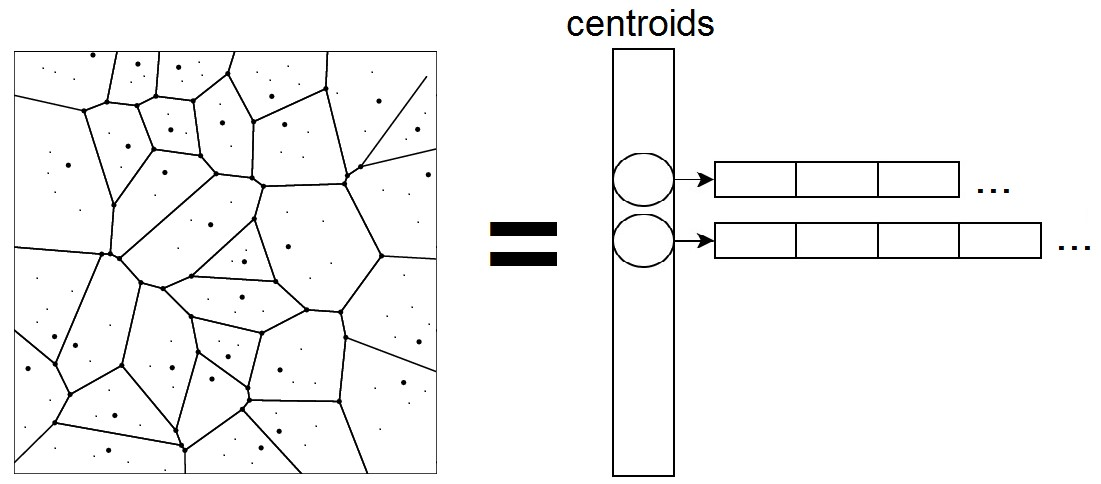

 [Facebook](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/)

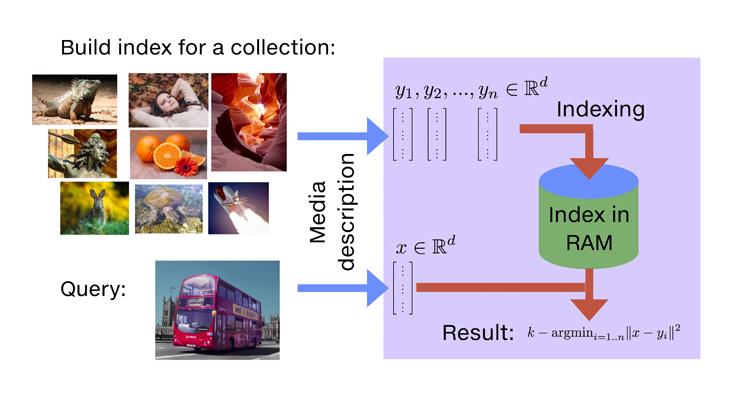


In [ ]:
import math
dim = sentence_embeddings.shape[1]
size = sentence_embeddings.shape[0]

In [ ]:
MODE = 'DOT'

if MODE == 'DOT':
  metric = faiss.METRIC_INNER_PRODUCT
  nlist = min(4096, 8 * round(math.sqrt(size)))
  if size < 100 * 10000:
          fac_str = "Flat"  # same
  elif size < 200 * 10000:
          fac_str = "IVF" + str(nlist) + ",Flat"  # same
  elif size < 500 * 10000:
          fac_str = "IVF16384,Flat"  # same
  else:
          fac_str = "IVF16384,PQ8"  # same


  nprobe = 8
  index = faiss.index_factory(dim, fac_str, metric)
  index.train(sentence_embeddings)
  index.nprobe = min(nprobe, nlist)
  assert index.is_trained
  index.add(sentence_embeddings)

else:
  index = faiss.IndexFlatL2(dim)
  print(index.ntotal)
  index.add(sentence_embeddings)
  print(index.ntotal)

In [ ]:
query = get_embeddings(['Искуственный интеллект'], model, tokenizer, bsize=1024)

cuda is used


1it [00:00, 18.25it/s]


In [ ]:
topn = 5
D, I = index.search(query, topn)
print(I)
print(D)

[[44566 78526 78522 44568 44567]]
[[234.73544 234.72173 222.82692 222.74371 218.29385]]


In [ ]:
def sem_search_faiss(q, index, values, top_k=5):
  query = get_embeddings(q, model, tokenizer, bsize=1024)
  D, I = index.search(query, top_k)
  resp = np.array(values)[I]
  return resp

In [ ]:
sem_search_faiss(
           q=['Искуственный интеллект'],
           index=index,
           values = np.array(science_news),
           top_k=5
           )

cuda is used


1it [00:00, 19.59it/s]


array([['Создан искусственный интеллект, превосходящий человека в интуиции',
        'Создан искусственный интеллект способный на самостоятельную эволюцию',
        'Создан искусственный разум, способный к эволюции',
        'Ученые создали искусственный интеллект с невероятной интуицией',
        'Ученые создали искусственный интеллект, превосходящий человека в интуиции']],
      dtype='<U359')